# Minimal PyTorch LSTM

In [1]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [2]:
# Give the nTheotebook access to the rest o1024f your google drive files.
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
# Enter the relevant foldername
FOLDERNAME = '/content/drive/My Drive/ML/Udacity_DLWPT/recurrent-neural-networks/char-rnn/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

Mounted at /content/drive


## Load data

In [3]:
# open text file and read in data as `text`
file_name = 'websters'
with open(FOLDERNAME +'data/' + f'{file_name}' + '.txt', 'r') as f:
    text = f.read()
print('Text length:', f'{len(text):.3E}')

Text length: 2.796E+07


### Tokenization

Get all unique chars and create dictionaries for encoding/decoding.

In [4]:
# encode the text and map each character to an integer and vice versa

# we create two dictionaries:
# 1. int2char, which maps integers to characters
# 2. char2int, which maps characters to unique integers
chars = tuple(set(text))
int2char = dict(enumerate(chars))
char2int = {ch: ii for ii, ch in int2char.items()}

# encode the text
encoded = np.array([char2int[ch] for ch in text])

In [5]:

print(*[f'{ch}' for ch in chars], f'Total characters: {len(chars)}', sep='\n')

s
6
î
w
)
X
7
½
D
"
(
ï
 
W
$
æ
#
*
_
B
â
o
å
m
¼
¿
-
~
\
R
v
K
N
r
b
M
ë
@
Z
=
	
C
I
;
º
l
﻿
a
4
ò
z
1
ð
d
[
.
^
ä
è
3
ý
E
á
%
f
>
h
e
V
ì
&
ô
n
!
9
÷
:
O
<
ü
c
G
{
T
þ
Y
j
é
P
0
A
x
ó
°
ù
|
H
ú
k
S
ã


Q
y
ñ
ê
Æ
2
L
ö
i
J
Þ
t
Ç
É
£
+
Ü
F
'
5
p
§
`
}
×
8
,
U
u
]
ç
à
û
/
¾
í
q
g
Total characters: 140


And we can see those same characters from above, encoded as integers.

## One-Hot Encoding

In [6]:
def one_hot_encode(arr, n_chars):
    # Initialize the encoded array
    one_hot = np.zeros((arr.size, n_chars), dtype=np.float32)
    # Fill the appropriate elements with ones via NumPy syntax
    one_hot[np.arange(one_hot.shape[0]), arr.flatten()] = 1.
    # Finally reshape it to get back to the original array
    one_hot = one_hot.reshape((*arr.shape, n_chars))
    
    return one_hot

In [7]:
# check that the function works as expected
test_seq = np.array([[3, 5, 1], [3, 5, 1]])
one_hot = one_hot_encode(test_seq, 8)
print(one_hot, one_hot.shape, sep='\n')

[[[0. 0. 0. 1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 1. 0. 0.]
  [0. 1. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 1. 0. 0.]
  [0. 1. 0. 0. 0. 0. 0. 0.]]]
(2, 3, 8)


## Making training mini-batches


To train on this data, we also want to create mini-batches for training. Remember that we want our batches to be multiple sequences of some desired number of sequence steps. Considering a simple example, our batches would look like this:

<img src="assets/sequence_batching@1x.png" width=500px>


<br>

In this example, we'll take the encoded characters (passed in as the `arr` parameter) and split them into multiple sequences, given by `batch_size`. Each of our sequences will be `seq_length` long.

### Creating Batches

**1. The first thing we need to do is discard some of the text so we only have completely full mini-batches. **

Each batch contains $N \times M$ characters, where $N$ is the batch size (the number of sequences in a batch) and $M$ is the seq_length or number of time steps in a sequence. Then, to get the total number of batches, $K$, that we can make from the array `arr`, you divide the length of `arr` by the number of characters per batch. Once you know the number of batches, you can get the total number of characters to keep from `arr`, $N * M * K$. **(GG: Confusing wording. K is the number of batches which are each of size N which each contain M characters.)**

**2. After that, we need to split `arr` into $N$ batches. ** 

You can do this using `arr.reshape(size)` where `size` is a tuple containing the dimensions sizes of the reshaped array. We know we want $N$ sequences in a batch, so let's make that the size of the first dimension. For the second dimension, you can use `-1` as a placeholder in the size, it'll fill up the array with the appropriate data for you. After this, you should have an array that is $N \times (M * K)$.

**3. Now that we have this array, we can iterate through it to get our mini-batches. **

The idea is each batch is a $N \times M$ window on the $N \times (M * K)$ array. For each subsequent batch, the window moves over by `seq_length`. We also want to create both the input and target arrays. Remember that the targets are just the inputs shifted over by one character. The way I like to do this window is use `range` to take steps of size `n_steps` from $0$ to `arr.shape[1]`, the total number of tokens in each sequence. That way, the integers you get from `range` always point to the start of a batch, and each window is `seq_length` wide.

> **TODO:** Write the code for creating batches in the function below. The exercises in this notebook _will not be easy_. I've provided a notebook with solutions alongside this notebook. If you get stuck, checkout the solutions. The most important thing is that you don't copy and paste the code into here, **type out the solution code yourself.**

In [8]:
def get_batches(arr, batch_size, seq_length):
    """Create a generator that returns batches of size
       batch_size x seq_length from arr.
       
       Arguments
       ---------
       arr: Array you want to make batches from
       batch_size: Batch size, the number ofn_batches sequences per batch
       seq_length: Number of encoded chars in a sequence
    """
    
    ## TODO: Get the *total* number of batches we can make
    # GG: len(arr) / (batch_size * seq_length) is the total number of batches, 
    # which we round down.
    n_batches = len(arr) // (batch_size * seq_length)
    if n_batches < 1:
        print('No full batches possible. Reduce batch_size and/or seq_length')
        return 
    
    ## TODO: Keep only enough characters to make full batches
    arr = arr[:n_batches * batch_size * seq_length]
    
    ## TODO: Reshape into batch_size rows
    arr = arr.reshape(batch_size, -1)
    
    ## TODO: Iterate over the batches using a window of size seq_length
    for n in range(0, arr.shape[1], seq_length):
        # The features
        x = arr[:, n: n + seq_length]
        # The targets, shifted by one/
        # GG: for final generator call, need to wrap last elements of y around
        # to avoid index errors.  The video does a try-except construction, but 
        # I wanted to try this:
        y = np.zeros_like(x)
        if n + seq_length != arr.shape[1]:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, n + seq_length]
        else:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, 0]
        # Original below. Theirs is probably nicer
        # try:
        #     y[:, :-1], y[:, -1] = x[:, 1:], arr[:, n+seq_length]
        # except IndexError:
        #     y[:, :-1], y[:, -1] = x[:, 1:], arr[:, 0]
        yield x, y

### Test Your Implementation

Now I'll make some data sets and we can check out what's going on as we batch data. Here, as an example, I'm going to use a batch size of 8 and 50 sequence steps.

In [9]:
batches = get_batches(encoded, 8, 50)
x, y = next(batches)
print(x.shape)

(8, 50)


In [10]:
# printing out the first 10 items in a sequence
print('x\n', x[:10, :10])
print('\ny\n', y[:10, :10])

x
 [[ 46  83  66  67  12  88  33  21  86  67]
 [ 53  33  47  45  12  80  66  47 122 113]
 [ 64  12  53 110   0  80  21 130  72 113]
 [ 21  64  12  47  12  45  47  33 139  67]
 [ 83 101 108  67   0 113 128  12  47  55]
 [ 72 139  55 131 101 101  88  61  90  19]
 [ 47 110 113  12 110  72  12   3  66 110]
 [103 128 101 130   0 130  47  45  45 103]]

y
 [[ 83  66  67  12  88  33  21  86  67  80]
 [ 33  47  45  12  80  66  47 122 113  67]
 [ 12  53 110   0  80  21 130  72 113 110]
 [ 64  12  47  12  45  47  33 139  67  12]
 [101 108  67   0 113 128  12  47  55 101]
 [139  55 131 101 101  88  61  90  19  77]
 [110 113  12 110  72  12   3  66 110  80]
 [128 101 130   0 130  47  45  45 103  12]]


If you implemented `get_batches` correctly, the above output should look something like 
```
x
 [[25  8 60 11 45 27 28 73  1  2]
 [17  7 20 73 45  8 60 45 73 60]
 [27 20 80 73  7 28 73 60 73 65]
 [17 73 45  8 27 73 66  8 46 27]
 [73 17 60 12 73  8 27 28 73 45]
 [66 64 17 17 46  7 20 73 60 20]
 [73 76 20 20 60 73  8 60 80 73]
 [47 35 43  7 20 17 24 50 37 73]]

y
 [[ 8 60 11 45 27 28 73  1  2  2]
 [ 7 20 73 45  8 60 45 73 60 45]
 [20 80 73  7 28 73 60 73 65  7]
 [73 45  8 27 73 66  8 46 27 65]
 [17 60 12 73  8 27 28 73 45 27]
 [64 17 17 46  7 20 73 60 20 80]
 [76 20 20 60 73  8 60 80 73 17]
 [35 43  7 20 17 24 50 37 73 36]]
 ```
 although the exact numbers may be different **(GG: why?)**. Check to make sure the data is shifted over one step for `y`.

---
## Defining the network with PyTorch

Below is where you'll define the network.

<img src="assets/CharLSTMM.png" width=500px>

Next, you'll use PyTorch to define the architecture of the network. We start by defining the layers and operations we want. Then, define a method for the forward pass. You've also been given a method for predicting characters.

### Model Structure

In `__init__` the suggested structure is as follows:
* Create and store the necessary dictionaries (this has been done for you)
* Define an LSTM layer that takes as params: an input size (the number of characters), a hidden layer size `n_hidden`, a number of layers `n_layers`, a dropout probability `drop_prob`, and a batch_first boolean (True, since we are batching)
* Define a dropout layer with `drop_prob` **(GG: Why not use LSTM's `dropout` option? Looks like they do)**
* Define a fully-connected layer with params: input size `n_hidden` and output size (the number of characters)
* Finally, initialize the weights (again, this has been given)

Note that some parameters have been named and given in the `__init__` function, and we use them and store them by doing something like `self.drop_prob = drop_prob`.

---
### LSTM Inputs/Outputs

You can create a basic [LSTM layer](https://pytorch.org/docs/stable/nn.html#lstm) as follows

```python
self.lstm = nn.LSTM(input_size, n_hidden, n_layers, 
                            dropout=drop_prob, batch_first=True)
```

where `input_size` is the number of characters this cell expects to see as sequential input, and `n_hidden` is the number of units in the hidden layers in the cell. And we can add dropout by adding a dropout parameter with a specified probability; this will automatically add dropout to the inputs or outputs. Finally, in the `forward` function, we can stack up the LSTM cells into layers using `.view`. With this, you pass in a list of cells and it will send the output of one cell into the next cell.

We also need to create an initial hidden state of all zeros. This is done like so

```python
self.init_hidden()
```

In [11]:
# check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [12]:
class CharLSTM(nn.Module):
    """
    GG: Would like to understand how n_hidden and n_layers are chosen.  n_hidden is
    O(sentence size), maybe?

    - tokens is the set of all possible characters
    """
    def __init__(self, tokens, n_hidden=1024, n_layers=2,
                               drop_prob=0.2, lr=0.001):
        super().__init__()
        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.lr = lr
        
        # creating character dictionaries, as before
        self.chars = tokens
        self.int2char = dict(enumerate(self.chars))
        self.char2int = {ch: ii for ii, ch in self.int2char.items()}
        
        ## TODO: define the layers of the model
        # We are one-hot encoding, so the inputs are of length of the vocab
        self.lstm = nn.LSTM(len(self.chars),
                            self.n_hidden, 
                            self.n_layers, 
                            batch_first=True, 
                            dropout=self.drop_prob)
        # They add in a dropout layer, so I'll just follow them. Guess it's not
        # redundant w/ LSTM dropouts
        self.dropout = nn.Dropout(self.drop_prob)
        # GG: Use CrossEntropyLoss so that we only output raw scores
        self.fc1 = nn.Linear(self.n_hidden,
                             len(self.chars))
        
      
    
    def forward(self, x, hidden):
        """Forward pass through the network. 
        These inputs are x, and the hidden/cell state `hidden`.
        """
                
        ## TODO: Get the outputs and the new hidden state from the lstm
        # Pass through LSTM, dropout, and linear
        x, hidden = self.lstm(x, hidden)
        x = self.dropout(x)
        # Collapsing every element in each batch to a single dimension
        x = x.contiguous().view(-1, self.n_hidden)
        x = self.fc1(x)
        # Output x is of shape x.shape = (batch_size * seq_length, self.chars)
        # giving batch_size * seq_length predictions for the next character which can be checked
        
        return x, hidden
    
    
    def init_hidden(self, batch_size):
        """Initializes hidden state.
        """
        # Create two new tensors with sizes n_layers x batch_size x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters())
        # Initialize to zero and move to appropriate device
        
        hidden = (weight.new_zeros(self.n_layers, batch_size, self.n_hidden),
                  weight.new_zeros(self.n_layers, batch_size, self.n_hidden))
        # GG: A little confused why we need this, since if we just don't pass in any
        # hidden state at all, it defaults to a zero tensor, no? This this just
        # makes later code cleaner.
        return hidden

In [13]:
# GG: testing
LSTM_test = CharLSTM(chars)
LSTM_test.to(device)
print(LSTM_test.char2int)
hidden_test = LSTM_test.init_hidden(batch_size=8)
print('hidden shape', hidden_test[0].shape)
x_test, _ = next(batches)
x_test = one_hot_encode(x_test, len(LSTM_test.chars))
x_test = torch.from_numpy(x_test).to(device)
print('data shape', x_test.shape)
print(LSTM_test(x_test, hidden_test)[0].shape, LSTM_test(x_test, hidden_test)[1][0].shape)
#LSTM_test(, hidden_0)
# The parameters are the weights and biases, not the hidden layer data
for param in LSTM_test.named_parameters():
    print('param:', param[0], 'shape:', param[1].shape)

{'s': 0, '6': 1, 'î': 2, 'w': 3, ')': 4, 'X': 5, '7': 6, '½': 7, 'D': 8, '"': 9, '(': 10, 'ï': 11, ' ': 12, 'W': 13, '$': 14, 'æ': 15, '#': 16, '*': 17, '_': 18, 'B': 19, 'â': 20, 'o': 21, 'å': 22, 'm': 23, '¼': 24, '¿': 25, '-': 26, '~': 27, '\\': 28, 'R': 29, 'v': 30, 'K': 31, 'N': 32, 'r': 33, 'b': 34, 'M': 35, 'ë': 36, '@': 37, 'Z': 38, '=': 39, '\t': 40, 'C': 41, 'I': 42, ';': 43, 'º': 44, 'l': 45, '\ufeff': 46, 'a': 47, '4': 48, 'ò': 49, 'z': 50, '1': 51, 'ð': 52, 'd': 53, '[': 54, '.': 55, '^': 56, 'ä': 57, 'è': 58, '3': 59, 'ý': 60, 'E': 61, 'á': 62, '%': 63, 'f': 64, '>': 65, 'h': 66, 'e': 67, 'V': 68, 'ì': 69, '&': 70, 'ô': 71, 'n': 72, '!': 73, '9': 74, '÷': 75, ':': 76, 'O': 77, '<': 78, 'ü': 79, 'c': 80, 'G': 81, '{': 82, 'T': 83, 'þ': 84, 'Y': 85, 'j': 86, 'é': 87, 'P': 88, '0': 89, 'A': 90, 'x': 91, 'ó': 92, '°': 93, 'ù': 94, '|': 95, 'H': 96, 'ú': 97, 'k': 98, 'S': 99, 'ã': 100, '\n': 101, 'Q': 102, 'y': 103, 'ñ': 104, 'ê': 105, 'Æ': 106, '2': 107, 'L': 108, 'ö': 109, '

## Time to train

The train function gives us the ability to set the number of epochs, the learning rate, and other parameters.

Below we're using an Adam optimizer and cross entropy loss since we are looking at character class scores as output. We calculate the loss and perform backpropagation, as usual!

A couple of details about training: 
>* Within the batch loop, we detach the hidden state from its history; this time setting it equal to a new *tuple* variable because an LSTM has a hidden state that is a tuple of the hidden and cell states.
* We use [`clip_grad_norm_`](https://pytorch.org/docs/stable/_modules/torch/nn/utils/clip_grad.html) to help prevent exploding gradients.

In [14]:
def train(net, data, epochs=10, batch_size=128, seq_length=100, lr=0.001, clip=5, val_frac=0.1, print_every=100):
    """Training a network 

    Arguments
    ---------

    net: CharLSTM network
    data: text data to train the network
    epochs: Number of epochs to train
    batch_size: Number of mini-sequences per mini-batch, aka batch size
    seq_length: Number of character steps per mini-batch
    lr: learning rate
    clip: gradient clipping
    val_frac: Fraction of data to hold out for validation
    print_every: Number of steps for printing training and validation loss
    """
    net.train()
    
    opt = torch.optim.Adam(net.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    # create training and validation data
    val_idx = int(len(data)*(1-val_frac))
    data, val_data = data[:val_idx], data[val_idx:]
    
    net.to(device)
    
    n_chars = len(net.chars)
    training_history, validation_history = [], []
    for e in range(epochs):
        # initialize hidden state
        h = net.init_hidden(batch_size)
        data_len = len(data) // batch_size // seq_length
        for idx, (x, y) in enumerate(get_batches(data, batch_size, seq_length)):
            # Progress counter
            progress_points = [int(data_len * step / 10) for step in range(1, 10)]
            if idx in progress_points:
                print(f'Epoch {e} {int(idx / data_len * 100)} percent complete')
            # One-hot encode our data and make them Torch tensors
            # Only encoding inputs, since targets don't go through network
            x = one_hot_encode(x, n_chars) 
            inputs, targets = torch.from_numpy(x), torch.from_numpy(y)
            
            inputs, targets = inputs.to(device), targets.to(device)

            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history
            # GG: confused about the issue here.  I think this is just ``truncated
            # backprop thorugh time" ??? 
            h = tuple(each.detach() for each in h)

            # zero accumulated gradients
            net.zero_grad()
            
            # get the output from the model
            output, h = net(inputs, h)
            
            # calculate the loss and perform backprop
            loss = criterion(output, targets.view(batch_size*seq_length).long())
            loss.backward()
            training_history.append(loss.item())
            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(net.parameters(), clip)
            opt.step()
            
        # loss stats at end of each epoch
        else:
            # Get validation loss
            val_h = net.init_hidden(batch_size)
            val_losses = []
            net.eval()
            for x, y in get_batches(val_data, batch_size, seq_length):
                # One-hot encode our data and make them Torch tensors
                x = one_hot_encode(x, n_chars)
                x, y = torch.from_numpy(x), torch.from_numpy(y)
                
                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                val_h = tuple([each.detach() for each in val_h])
                
                inputs, targets = x, y
              
                inputs, targets = inputs.to(device), targets.to(device)

                output, val_h = net(inputs, val_h)
                val_loss = criterion(output, targets.view(batch_size*seq_length).long())
            
                val_losses.append(val_loss.item())
                validation_history.append(val_loss.item())
            
            net.train() # reset to train mode after iterationg through validation data
            
            print(f"Epoch: {e + 1}/{epochs}...",
                  f"Loss: {loss.item():.4f}...",
                  f"Val Loss: {np.mean(val_losses):.4f}")
        
    # Training ended
    else:
        # Plot training loss history
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
        ax1.plot(training_history, label='Training Losses')
        ax1.legend()
        ax2.plot(validation_history, label='Validation Losses')
        ax2.legend()
        plt.show()

## Instantiating the model

Now we can actually train the network. First we'll create the network itself, with some given hyperparameters. Then, define the mini-batches sizes, and start training!

In [15]:
n_hidden, n_layers, batch_size, seq_length, n_epochs =128, 2, 1024, 256, 32
net = CharLSTM(chars, n_hidden=n_hidden, n_layers=n_layers)
print(net)
# total number of trainable parameters
total_trainable_params = sum(item.numel() for item in net.parameters() if item.requires_grad)
# The number of trainable parameters should be similar to text length (apparently)
print(f'Trainable Parameters: {total_trainable_params:.2E}', 'Text length:', f'{len(text):.3E}')

CharLSTM(
  (lstm): LSTM(140, 128, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=128, out_features=140, bias=True)
)
Trainable Parameters: 2.88E+05 Text length: 2.796E+07


Epoch 0 9 percent complete
Epoch 0 20 percent complete
Epoch 0 29 percent complete
Epoch 0 40 percent complete
Epoch 0 49 percent complete
Epoch 0 60 percent complete
Epoch 0 69 percent complete
Epoch 0 80 percent complete
Epoch 0 89 percent complete
Epoch: 1/32... Loss: 3.4536... Val Loss: 3.4299
Epoch 1 9 percent complete
Epoch 1 20 percent complete
Epoch 1 29 percent complete
Epoch 1 40 percent complete
Epoch 1 49 percent complete
Epoch 1 60 percent complete
Epoch 1 69 percent complete
Epoch 1 80 percent complete
Epoch 1 89 percent complete
Epoch: 2/32... Loss: 3.3835... Val Loss: 3.3621
Epoch 2 9 percent complete
Epoch 2 20 percent complete
Epoch 2 29 percent complete
Epoch 2 40 percent complete
Epoch 2 49 percent complete
Epoch 2 60 percent complete
Epoch 2 69 percent complete
Epoch 2 80 percent complete
Epoch 2 89 percent complete
Epoch: 3/32... Loss: 3.0059... Val Loss: 2.9698
Epoch 3 9 percent complete
Epoch 3 20 percent complete
Epoch 3 29 percent complete
Epoch 3 40 percent c

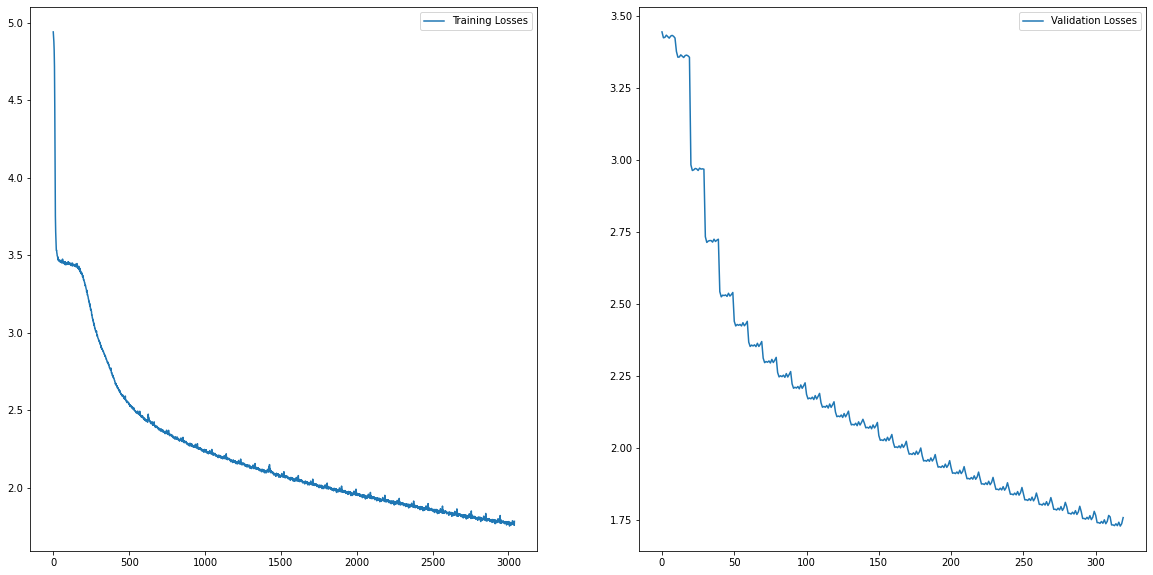

Training_time: 535.7324153489999


In [16]:
# train the model
start = time.perf_counter()
train(net, encoded, batch_size=batch_size, seq_length=seq_length, epochs=n_epochs)
training_time = time.perf_counter() - start
print('Training_time:', training_time)

## Getting the best model

To set your hyperparameters to get the best performance, you'll want to watch the training and validation losses. If your training loss is much lower than the validation loss, you're overfitting. Increase regularization (more dropout) or use a smaller network. If the training and validation losses are close, you're underfitting so you can increase the size of the network.

## Hyperparameters

Here are the hyperparameters for the network.

In defining the model:
* `n_hidden` - The number of units in the hidden layers.
* `n_layers` - Number of hidden LSTM layers to use.

We assume that dropout probability and learning rate will be kept at the default, in this example.

And in training:
* `batch_size` - Number of sequences running through the network in one pass.
* `seq_length` - Number of characters in the sequence the network is trained on. Larger is better typically, the network will learn more long range dependencies. But it takes longer to train. 100 is typically a good number here.
* `lr` - Learning rate for training

Here's some good advice from Andrej Karpathy on training the network. I'm going to copy it in here for your benefit, but also link to [where it originally came from](https://github.com/karpathy/char-rnn#tips-and-tricks).

> ## Tips and Tricks

>### Monitoring Validation Loss vs. Training Loss
>If you're somewhat new to Machine Learning or Neural Networks it can take a bit of expertise to get good models. The most important quantity to keep track of is the difference between your training loss (printed during training) and the validation loss (printed once in a while when the RNN is run on the validation data (by default every 1000 iterations)). In particular:

> - If your training loss is much lower than validation loss then this means the network might be **overfitting**. Solutions to this are to decrease your network size, or to increase dropout. For example you could try dropout of 0.5 and so on.
> - If your training/validation loss are about equal then your model is **underfitting**. Increase the size of your model (either number of layers or the raw number of neurons per layer)

> ### Approximate number of parameters

> The two most important parameters that control the model are `n_hidden` and `n_layers`. I would advise that you always use `n_layers` of either 2/3. The `n_hidden` can be adjusted based on how much data you have. The two important quantities to keep track of here are:

> - The number of parameters in your model. This is printed when you start training.
> - The size of your dataset. 1MB file is approximately 1 million characters.

>These two should be about the same order of magnitude. It's a little tricky to tell. Here are some examples:

> - I have a 100MB dataset and I'm using the default parameter settings (which currently print 150K parameters). My data size is significantly larger (100 mil >> 0.15 mil), so I expect to heavily underfit. I am thinking I can comfortably afford to make `n_hidden` larger.
> - I have a 10MB dataset and running a 10 million parameter model. I'm slightly nervous and I'm carefully monitoring my validation loss. If it's larger than my training loss then I may want to try to increase dropout a bit and see if that helps the validation loss.

> ### Best models strategy

>The winning strategy to obtaining very good models (if you have the compute time) is to always err on making the network larger (as large as you're willing to wait for it to compute) and then try different dropout values (between 0,1). Whatever model has the best validation performance (the loss, written in the checkpoint filename, low is good) is the one you should use in the end.

>It is very common in deep learning to run many different models with many different hyperparameter settings, and in the end take whatever checkpoint gave the best validation performance.

>By the way, the size of your training and validation splits are also parameters. Make sure you have a decent amount of data in your validation set or otherwise the validation performance will be noisy and not very informative.

## Checkpoint

After training, we'll save the model so we can load it again later if we need too. Here I'm saving the parameters needed to create the same architecture, the hidden layer hyperparameters and the text characters.

In [17]:
# change the name, for saving multiple files
model_name = FOLDERNAME + f'lstm_{file_name}_hidden_{n_hidden}_layers_{n_layers}_batch_{batch_size}_seq_{seq_length}_epochs_{n_epochs}.net'
# Save any information we might want later.
checkpoint = {'n_hidden': net.n_hidden,
              'n_layers': net.n_layers,
              'state_dict': net.state_dict(),
              'tokens': net.chars,
              'epochs': n_epochs,
              'seq_len': seq_length,
              'batch_size': batch_size,
              'training_time': training_time}

with open(model_name, 'wb') as f:
    torch.save(checkpoint, f)

---
## Making Predictions

Now that the model is trained, we'll want to sample from it and make predictions about next characters! To sample, we pass in a character and have the network predict the next character. Then we take that character, pass it back in, and get another predicted character. Just keep doing this and you'll generate a bunch of text!

### A note on the `predict`  function

The output of our RNN is from a fully-connected layer and it outputs a **distribution of next-character scores**.

> To actually get the next character, we apply a softmax function, which gives us a *probability* distribution that we can then sample to predict the next character.

### Top K sampling

Our predictions come from a categorical probability distribution over all the possible characters. We can make the sample text and make it more reasonable to handle (with less variables) by only considering some $K$ most probable characters. This will prevent the network from giving us completely absurd characters while allowing it to introduce some noise and randomness into the sampled text. Read more about [topk, here](https://pytorch.org/docs/stable/torch.html#torch.topk).


In [18]:
def predict(net, char, h=None, top_k=None):
        ''' Given a character, predict the next character.
            Returns the predicted character and the hidden state.
        '''
        
        # tensor inputs
        x = np.array([[net.char2int[char]]])
        x = one_hot_encode(x, len(net.chars))
        inputs = torch.from_numpy(x)
        
        inputs = inputs.to(device)
        
        # detach hidden state from history
        # GG: Just for speed? Not like we are backpropagating.
        h = tuple(each.detach() for each in h)
        # get the output of the model
        out, h = net(inputs, h)

        # get the character probabilities
        p = F.softmax(out, dim=1).detach().to(device)
        
        # get top characters
        if top_k is None:
            top_ch = np.arange(len(net.chars))
        else:
            p, top_ch = p.topk(top_k)
            p, top_ch = p.to('cpu'), top_ch.to('cpu')
            top_ch = top_ch.numpy().squeeze()
        
        # select the likely next character with some element of randomness
        p = p.numpy().squeeze()
        char = np.random.choice(top_ch, p=p/p.sum())
        
        # return the encoded value of the predicted char and the hidden state
        return net.int2char[char], h

### Priming and generating text 

Typically you'll want to prime the network so you can build up a hidden state. Otherwise the network will start out generating characters at random. In general the first bunch of characters will be a little rough since it hasn't built up a long history of characters to predict from.

In [21]:
def sample(net, size, prime='The', top_k=None):
        
    net.to(device)
    
    net.eval() # eval mode
    
    # First off, run through the prime characters
    chars = [ch for ch in prime]
    h = net.init_hidden(1)
    for ch in prime:
        char, h = predict(net, ch, h, top_k=top_k)
    chars.append(char)
    
    # Now pass in the previous character and get a new one
    for ii in range(size):
        char, h = predict(net, chars[-1], h, top_k=top_k)
        chars.append(char)

    return ''.join(chars)

In [23]:
print(sample(net, 3 * 10 ** 3, prime='The', top_k=3))

Thering and and to and a carter of a condent a
combondication and alling the sone and contentine
and compancices, or senching that and the camper and condering of
an a presser.

SAPTENTER
Cap"ten*ter, n.

Defn: A sentation of the part of steets.

PONERATER
Cun*erat"er, n.

Defn: The art of a proportion of the courte of
artion or senter of the superation of as the constroces of
the sure offence, and carled to a pares of a serfat of the caltent of
an or stees of a counted and assore.

3. To compated to so a paring of the sure of an anding a precest the some
as or stand of sear the passing the stere
stersed of the state as a poles or a store of
the ster and some a senste to someter of the perious of the
camporar of the contertatic and the senting of the
state the propersed. See Scalling.]

Defn: One who state; the parting an the compones of
such a parest of the passed of the strong, or the sear the
praction of the sup of as any the suchion and comporion.
The sound as the sond of the chart